In [7]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from numba import jit 
from sklearn.metrics import mean_squared_error, r2_score
@jit
def qwk(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / float(a1.shape[0])

    return 1 - o / e


def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

def qwk_score(y_true,y_pred):
    #print "RMSE", np.sqrt(mean_squared_error(y_true,y_pred))
    ypred=clip_pred(y_pred)
    return qwk(y_true,ypred)
    

In [3]:
import fastparquet
%time df=fastparquet.ParquetFile("../../input/lr_train_num_combined_latest_target_v2_with_Nystroem.parq").to_pandas()

CPU times: user 4.24 s, sys: 3.33 s, total: 7.58 s
Wall time: 8.24 s


In [4]:
df=df.loc[np.random.permutation(df.index)]

In [5]:
X=df.drop(['target','fold'],axis=1)
y=df['target']

In [6]:
trainx=X[y>=0]
trainy=y[y>=0]
testx=X[y<0]

In [7]:
folds=df[y>=0]['fold']

In [8]:
trainx.shape,testx.shape,trainy.shape, len(folds),set(trainy)

((5203955, 150),
 (1378521, 150),
 (5203955,),
 5203955,
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20})

In [9]:
del df,X,y

In [10]:
from sklearn.linear_model import ElasticNet,LinearRegression,Ridge

In [11]:
gc.collect()

4682

# grid search

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  make_scorer

In [13]:
alpha=10

In [14]:
def train():
    lst_valid=[]
    lst_test=[]
    for fold in range(5):
        print fold
        X_train=trainx[(folds<>fold)]
        y_train=trainy[(folds<>fold)]
        X_valid=trainx[(folds==fold)]
        y_valid=trainy[(folds==fold)]
        regr=Ridge(alpha=alpha)
        regr.fit(X_train,y_train)
        lst_test.append(pd.Series(regr.predict(testx),index=testx.index))
        lst_valid.append(pd.Series(regr.predict(X_valid),index=X_valid.index))
        print fold, regr.score(X_valid,y_valid) 
    return lst_valid,lst_test

In [15]:
lst_valid,lst_test=train()

0
0 0.583571158664
1
1 0.585908005941
2
2 0.585976273737
3
3 0.585404077563
4
4 0.584569551877


In [16]:
name='ridge1'

In [17]:
l1_train_pred=pd.concat(lst_valid).loc[trainx.index].astype(np.float32)
l1_train_pred.name=name+"_pred"
np.sqrt(r2_score(trainy,l1_train_pred)),qwk_score(trainy,l1_train_pred),mean_squared_error(trainy,l1_train_pred)

(0.76490933187037924, 0.7341527315538896, 3.663394)

In [18]:
l1_test_pred=(reduce(lambda u,v:u+v,lst_test)/float(len(lst_test))).astype(np.float32)
l1_test_pred.name=name+"_pred"

In [20]:
import cPickle as pickle
pickle.dump(l1_train_pred,open("../level1_train/{}_train_l1pred.pkl".format(name),'wb'))
pickle.dump(l1_test_pred,open("../level1_train/{}_test_l1pred.pkl".format(name),'wb'))

In [3]:
def make_submission(pred_s,filepath):
    df=pd.read_csv('../../input/sample_submission_v2.csv',index_col=0)
    df['target']=pred_s 
    df=np.round(df,0)
    df[df>20]=20
    df[df<0]=0
    df=df.astype(np.int32)
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}
def clip_pred(s):
    s=np.round(s)
    s[s<0]=0
    s[s>20]=20
    return s    

In [23]:
make_submission(l1_test_pred,"../level1_train/{}_test_l1pred.csv".format(name))

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


rm: cannot remove ‘../level1_train/ridge1_test_l1pred.csv.7z’: No such file or directory


In [1]:
import cPickle as pickle
import numpy as np

0.652262098292 0.933382919986


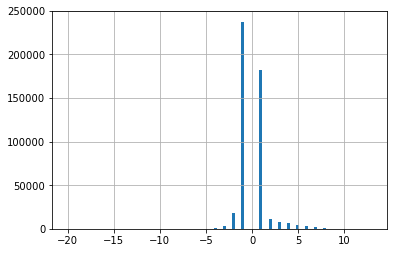

In [8]:
a=clip_pred(pickle.load(open("../level1_train/ridge1_test_l1pred.pkl")))
b=clip_pred(pickle.load(open("../level1_train/lars0_test_l1pred.pkl")))
b=b.loc[a.index]
d=(a-b)
print np.mean(d==0),np.corrcoef(a,b)[0,1]
d[d<>0].hist(bins=100)

0.7478602067 0.977217358266


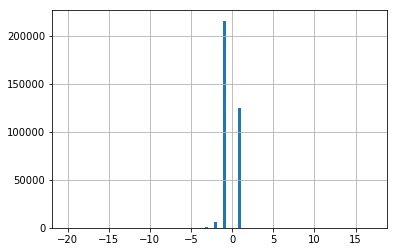

In [9]:
a=clip_pred(pickle.load(open("../level1_train/ridge1_test_l1pred.pkl")))
b=clip_pred(pickle.load(open("../level1_train/ridge0_test_l1pred.pkl")))
b=b.loc[a.index]
d=(a-b)
print np.mean(d==0),np.corrcoef(a,b)[0,1]
d[d<>0].hist(bins=100)